In [1]:
import json
import random
import sys

import numpy as np

sys.path.insert(1, '../../src')

from ce.algorithms.local_search.local_search_cache import steepest_local_search_cache
from ce.algorithms.local_search.neighbor.candidate_moves import calculate_candidate_edges
from ce.algorithms.greedy_heuristics import random_solution
from ce.algorithms.local_search import steepest_local_search, two_edges_neighborhood, two_nodes_neighborhood, \
    steepest_local_candidates_search, two_edges_candidates_neighborhood, two_nodes_candidates_neighborhood
from ce.tsp import create_tsp, TSP
from ce.utils.experiments import run_all_experiments

# The use of move evaluations (deltas) from previous iterations in local search

**Nina Zukowska 148278, Antoni Solarski 148270**

In [2]:
problem_instance_A_path = '../../data/TSPA.csv'
problem_instance_B_path = '../../data/TSPB.csv'
problem_instance_C_path = '../../data/TSPC.csv'
problem_instance_D_path = '../../data/TSPD.csv'

In [3]:
tspa, tspb, tspc, tspd = create_tsp(problem_instance_A_path), create_tsp(problem_instance_B_path), create_tsp(
    problem_instance_C_path), create_tsp(problem_instance_D_path)

## Algorithms

---

### Steepest local search (with cache)

```python
def steepest_local_search_cache(tsp: TSP, init_solution, neighborhood_fn):
    solution = init_solution
    local_optimum, counter = False, 0
    cost_delta_matrix = get_cost_delta_matrix(neighborhood_fn, solution, tsp)

    while not local_optimum:
        best_neighbor = min(cost_delta_matrix, key=cost_delta_matrix.get)
        if cost_delta_matrix[best_neighbor] < 0:
            new_sol = get_new_solution(best_neighbor, solution)
            update_matrix(cost_delta_matrix, best_neighbor, solution, new_sol, get_move_types(neighborhood_fn), tsp)
            solution = new_sol
            counter += 1
        else:
            local_optimum = True

    return solution, counterion, counter

```

---

### Cost delta matrix creation

```python
def get_cost_delta_matrix(neighborhood_fn, solution, tsp: TSP):
    return {
        n: get_cost_delta(n, solution, tsp)
        for n in neighborhood_fn(solution, tsp)
    }
```

---

### Cost delta matrix updates

#### Inter route exchange

```python
def update_matrix_inter(matrix: dict, solution: List[int], new_solution: List[int], move: Tuple[int, int],
                        move_types: List[int], tsp: TSP):
    position, outer_node = move
    node_to_replace = solution[position]
    position_before, position_after = (position - 1) % len(solution), (position + 1) % len(solution)

    # inter moves
    if 0 in move_types:
        for i, _ in enumerate(solution):
            # remove inserted outer_node from cache
            del matrix[(0, (i, outer_node))]
            # calculate costs for removed node
            matrix[(0, (i, node_to_replace))] = get_cost_delta((0, (i, node_to_replace)), new_solution, tsp)
        for n in set(tsp.indexes) - set(new_solution):
            # recalculate for nodes adjacent to the exchanged one
            for r in (position_before, position, position_after):
                matrix[(0, (r, n))] = get_cost_delta((0, (r, n)), new_solution, tsp)

    # 2-nodes moves
    if 1 in move_types:
        for i, _ in enumerate(solution):
            # recalculate for nodes adjacent to the exchanged one
            for j in (position_before, position, position_after):
                if 0 < i < j:
                    matrix[(1, (i, j))] = get_cost_delta((1, (i, j)), new_solution, tsp)
                if 0 < j < i:
                    matrix[(1, (j, i))] = get_cost_delta((1, (j, i)), new_solution, tsp)

    # 2-edges moves
    if 2 in move_types:
        for i, _ in enumerate(solution):
            # recalculate for edges that touch exchanged node
            for j in (position_before, position):
                if i < j and (j - i) > 1 and not (i == 0 and j == len(solution) - 1):
                    matrix[(2, (i, j))] = get_cost_delta((2, (i, j)), new_solution, tsp)
                if j < i and (i - j) > 1 and not (j == 0 and i == len(solution) - 1):
                    matrix[(2, (j, i))] = get_cost_delt
```

#### 2-nodes exchange


```python
def update_matrix_2nodes(matrix: dict, solution: List[int], new_solution: List[int], move: Tuple[int, int],
                         move_types: List[int], tsp: TSP):
    pos1, pos2 = move
    before1, after1 = (pos1 - 1) % len(solution), (pos1 + 1) % len(solution)
    before2, after2 = (pos2 - 1) % len(solution), (pos2 + 1) % len(solution)

    # inter moves
    if 0 in move_types:
        for n in set(tsp.indexes) - set(new_solution):
            # update rows (-/+ 1) (corresponding to replacement position in solution)
            for r in {pos1, pos2, before1, before2, after1, after2}:
                matrix[(0, (r, n))] = get_cost_delta((0, (r, n)), new_solution, tsp)

    # 2-nodes moves
    if 1 in move_types:
        for i, _ in enumerate(solution):
            # update rows (-/+ 1) (corresponding to replacement position in solution)
            for j in {pos1, pos2, before1, before2, after1, after2}:
                if 0 < i < j:
                    matrix[(1, (i, j))] = get_cost_delta((1, (i, j)), new_solution, tsp)
                if 0 < j < i:
                    matrix[(1, (j, i))] = get_cost_delta((1, (j, i)), new_solution, tsp)

    # 2-edges moves
    if 2 in move_types:
        pass
```

#### 2-edges exchange

```python
def update_matrix_2edges(matrix: dict, solution: List[int], new_solution: List[int], move: Tuple[int, int],
                         move_types: List[int], tsp: TSP):
    e1, e2 = move
    from1, to1 = e1, (e1 + 1) % len(solution)
    from2, to2 = e2, (e2 + 1) % len(solution)

    # inter moves
    if 0 in move_types:
        for n in set(tsp.indexes) - set(new_solution):
            # recalculate for nodes in exchange
            for r in {from1, to1, from2, to2}:
                matrix[(0, (r, n))] = get_cost_delta((0, (r, n)), new_solution, tsp)
            # swap for nodes where direction was changed
            for r in range((from2 - to1) // 2):
                a, b = to1 + 1 + r, from2 - r - 1
                matrix[(0, (a, n))], matrix[(0, (b, n))] = matrix[(0, (b, n))], matrix[(0, (a, n))]

    # 2-nodes moves
    if 1 in move_types:
        pass

    # 2-edges moves
    if 2 in move_types:
        for i, _ in enumerate(solution):
            # recalculate for edges between the whole exchange
            for j in range(from1, from2 + 1):
                if i < j and (j - i) > 1 and not (i == 0 and j == len(solution) - 1):
                    matrix[(2, (i, j))] = get_cost_delta((2, (i, j)), new_solution, tsp)
                if j < i and (i - j) > 1 and not (j == 0 and i == len(solution) - 1):
                    matrix[(2, (j, i))] = get_cost_delta((2, (j, i)), new_solution, tsp)
```

---

## Experiments

In [4]:
n_runs = 200
experiments = [
    "S_r_2nodes",
    "S_r_2n_cch",
    "S_r_2n_c10",
    "S_r_2edges",
    "S_r_2e_cch",
    "S_r_2e_c10",
]


def experiments_provider(tsp: TSP, random_inits):
    return [
        lambda x: steepest_local_search(tsp, random_inits[x], two_nodes_neighborhood),
        lambda x: steepest_local_search_cache(tsp, random_inits[x], two_nodes_neighborhood),
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_nodes_candidates_neighborhood, calculate_candidate_edges(tsp, 10)),
        lambda x: steepest_local_search(tsp, random_inits[x], two_edges_neighborhood),
        lambda x: steepest_local_search_cache(tsp, random_inits[x], two_edges_neighborhood),
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_edges_candidates_neighborhood, calculate_candidate_edges(tsp, 10)),
    ]

### Instance C

**************************************************************************************************
S_r_2nodes:	cost: 66196.6, (58060 - 74151)	|	iter: 153.2, (124 - 224)	|	time: 3.7s, (3.0s - 5.4s)
S_r_2n_cch:	cost: 66202.1, (58060 - 74151)	|	iter: 153.2, (124 - 224)	|	time: 0.4s, (0.3s - 0.6s)
S_r_2n_c10:	cost: 67336.3, (60217 - 77251)	|	iter: 145.5, (116 - 190)	|	time: 0.6s, (0.5s - 0.8s)
S_r_2edges:	cost: 51552.7, (48758 - 54523)	|	iter: 132.3, (108 - 148)	|	time: 2.7s, (2.2s - 3.0s)
S_r_2e_cch:	cost: 51555.8, (48758 - 54751)	|	iter: 132.3, (108 - 148)	|	time: 0.5s, (0.4s - 0.6s)
S_r_2e_c10:	cost: 51551.4, (48763 - 54068)	|	iter: 131.3, (107 - 155)	|	time: 0.4s, (0.3s - 0.5s)
**************************************************************************************************




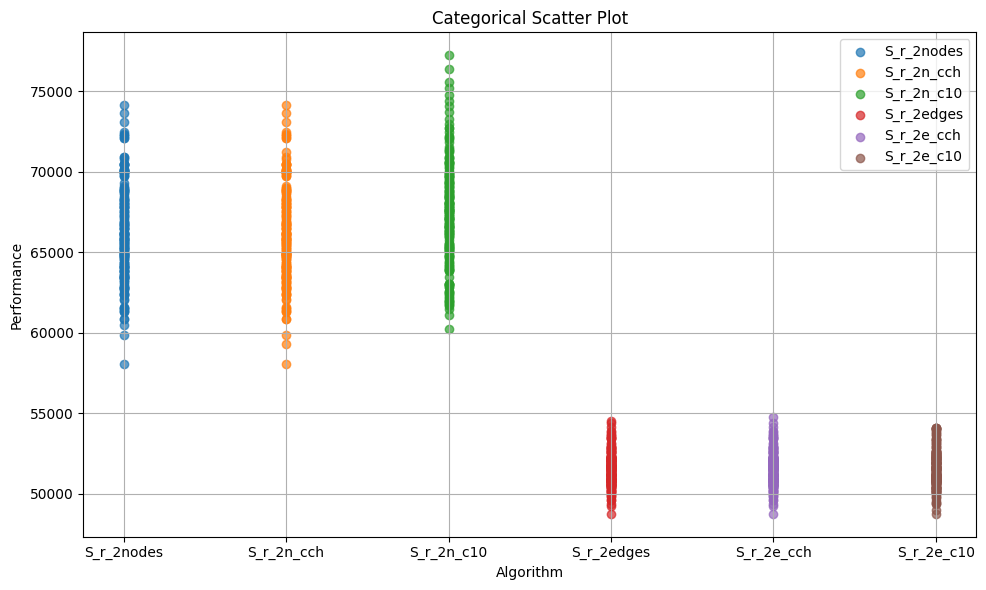

CPU times: total: 27min 26s
Wall time: 27min 26s


In [5]:
%%time
random.seed(13)
np.random.seed(13)
random_inits_c = [random_solution(tspc) for i in range(n_runs)]

best_solutions_c, results_list_c = run_all_experiments(
    n_runs, experiments_provider(tspc, random_inits_c), tspc.get_solution_cost, experiments)

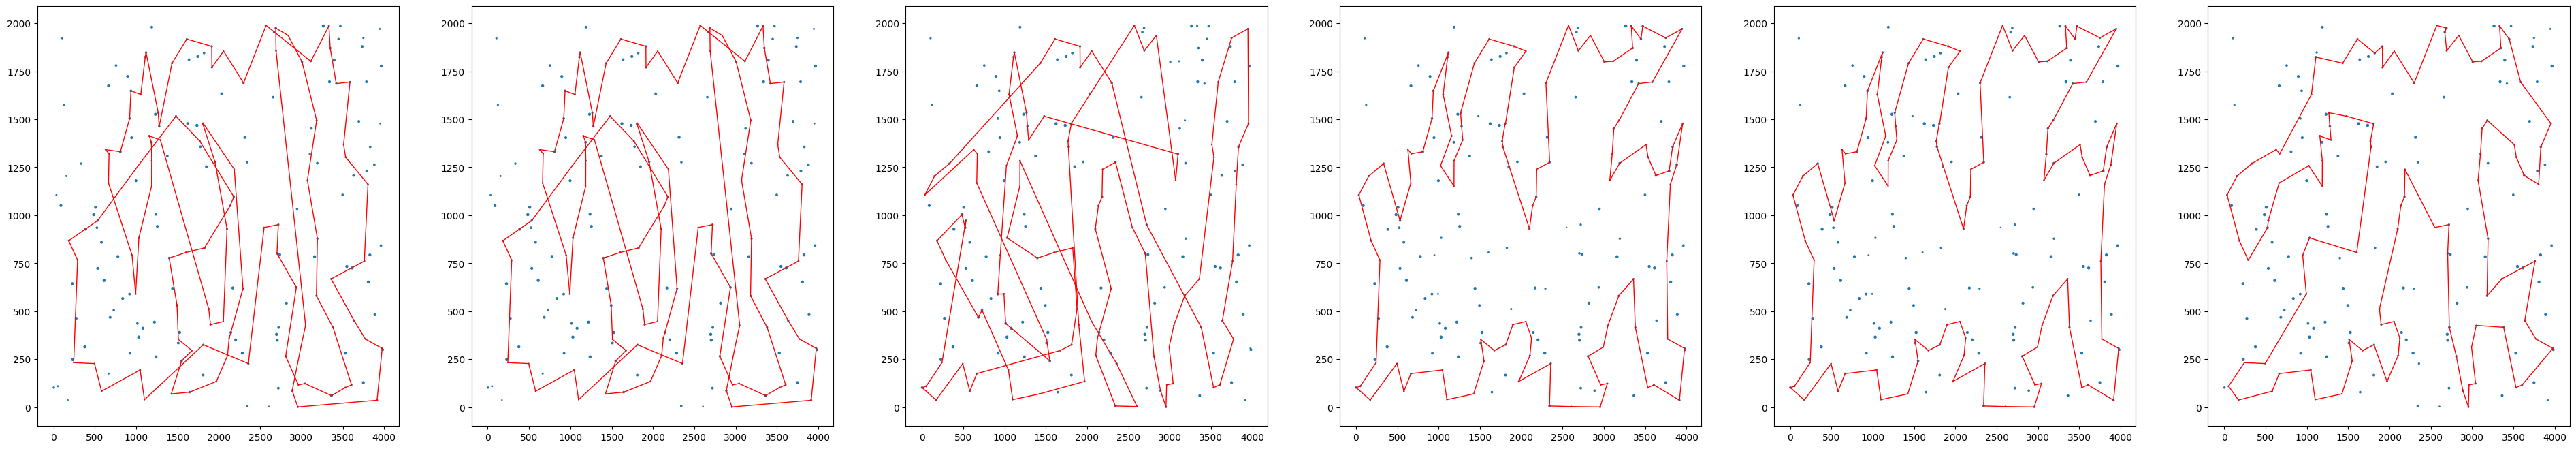

In [6]:
tspc.plot(best_solutions_c)

### Instance D


**************************************************************************************************
S_r_2nodes:	cost: 64193.8, (55112 - 74348)	|	iter: 154.6, (119 - 201)	|	time: 3.8s, (2.9s - 4.9s)
S_r_2n_cch:	cost: 64174.2, (55151 - 74348)	|	iter: 154.8, (119 - 201)	|	time: 0.4s, (0.3s - 0.5s)
S_r_2n_c10:	cost: 65694.4, (56772 - 80187)	|	iter: 146.1, (116 - 197)	|	time: 0.6s, (0.5s - 0.8s)
S_r_2edges:	cost: 48338.9, (45583 - 52112)	|	iter: 133.8, (117 - 157)	|	time: 2.8s, (2.5s - 3.3s)
S_r_2e_cch:	cost: 48349.3, (45583 - 51626)	|	iter: 133.8, (117 - 157)	|	time: 0.5s, (0.3s - 0.6s)
S_r_2e_c10:	cost: 48261.7, (45228 - 52383)	|	iter: 133.1, (118 - 155)	|	time: 0.4s, (0.4s - 0.5s)
**************************************************************************************************




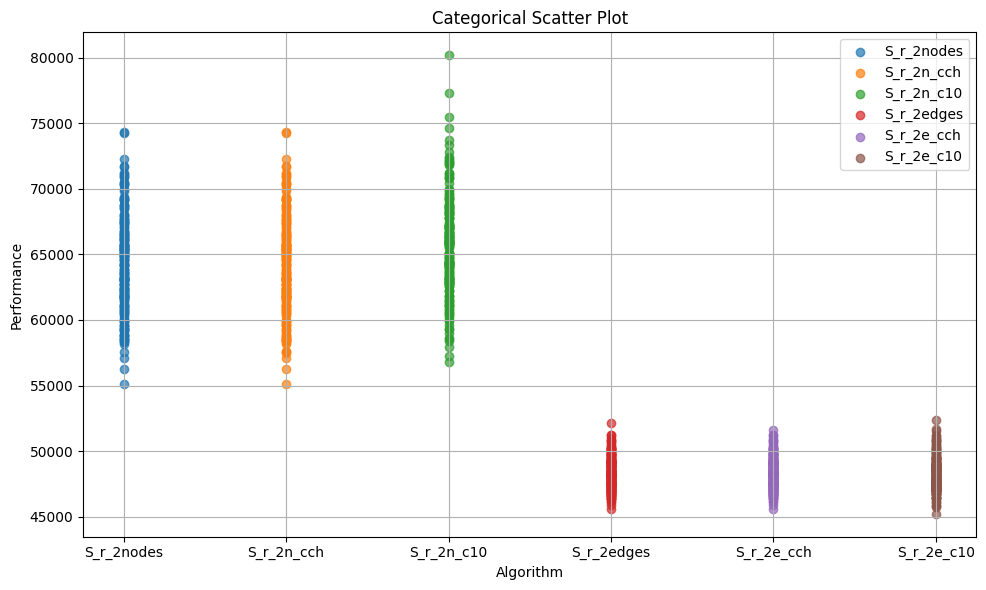

CPU times: total: 28min 18s
Wall time: 28min 18s


In [7]:
%%time
random.seed(13)
np.random.seed(13)
random_inits_d = [random_solution(tspd) for i in range(n_runs)]

best_solutions_d, results_list_d = run_all_experiments(
    n_runs, experiments_provider(tspd, random_inits_d), tspd.get_solution_cost, experiments)

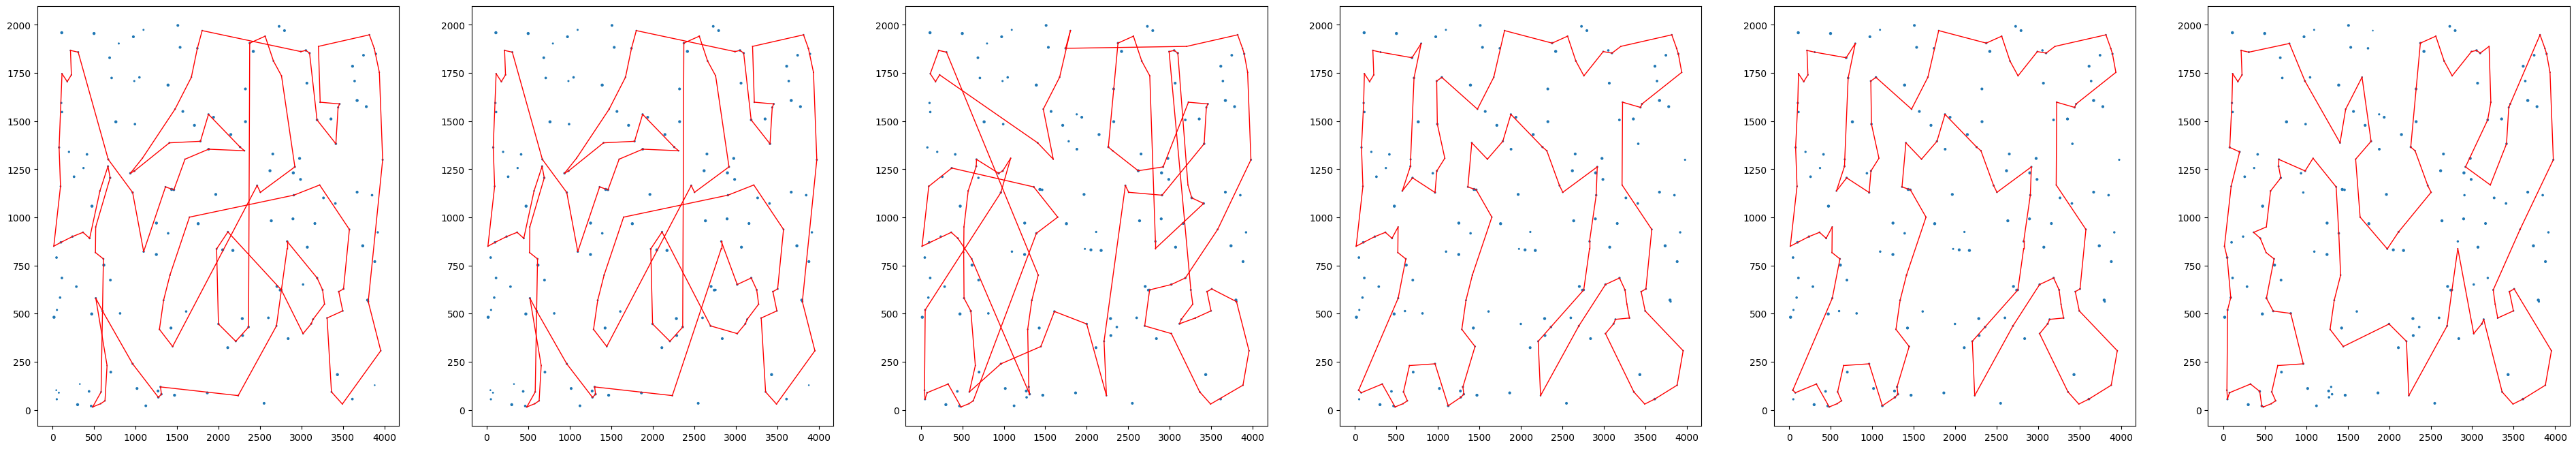

In [8]:
tspd.plot(best_solutions_d)

In [9]:
with open('results_c.json', 'w', encoding='utf-8') as f:
    json.dump(results_list_c, f, ensure_ascii=False, indent=4)
with open('best_solutions_c.json', 'w', encoding='utf-8') as f:
    json.dump(best_solutions_c, f, ensure_ascii=False, indent=4)

In [10]:
with open('results_d.json', 'w', encoding='utf-8') as f:
    json.dump(results_list_d, f, ensure_ascii=False, indent=4)
with open('best_solutions_d.json', 'w', encoding='utf-8') as f:
    json.dump(best_solutions_d, f, ensure_ascii=False, indent=4)

## Conclusions

We clearly proved that the usage of previous computation can speed up the steepest local search. Taking an average from all experiments it looks like it can make the computation even an order of magnitude faster without any compromise when it comes to the solution quality(*).

(*) - it looks like there are some slight differences between single runs with and without cache, but I assume it could have been caused by choosing the different move from two neighbors with the same cost delta, as running all experiments with the following assertion didn't show any differences.

```python
def steepest_local_search_cache(tsp: TSP, init_solution, neighborhood_fn):
    solution = init_solution
    local_optimum, counter = False, 0
    cost_delta_matrix = get_cost_delta_matrix(neighborhood_fn, solution, tsp)

    while not local_optimum:
        best_neighbor = min(cost_delta_matrix, key=cost_delta_matrix.get)
        if cost_delta_matrix[best_neighbor] < 0:
            new_sol = get_new_solution(best_neighbor, solution)
            update_matrix(cost_delta_matrix, best_neighbor, solution, new_sol, get_move_types(neighborhood_fn), tsp)
            assert cost_delta_matrix == get_cost_delta_matrix(neighborhood_fn, new_solution, tsp)
            solution = new_sol
            counter += 1
        else:
            local_optimum = True

    return solution, counterion, counter
```